In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
#import the data
file_path = '/content/drive/My Drive/Crime_Data_from_2020_to_Present.csv'
data = pd.read_csv(file_path)

In [3]:
data.shape

(694915, 28)

In [4]:
data.isnull().sum()

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes            95563
Vict Age               0
Vict Sex           91046
Vict Descent       91052
Premis Cd              8
Premis Desc          366
Weapon Used Cd    453481
Weapon Desc       453481
Status                 0
Status Desc            0
Crm Cd 1               9
Crm Cd 2          643099
Crm Cd 3          693168
Crm Cd 4          694863
LOCATION               0
Cross Street      582058
LAT                    0
LON                    0
dtype: int64

In [5]:
#dropping the unnecessary columns
data.drop(['DR_NO', 'Date Rptd', 'Rpt Dist No' , 'Part 1-2',  'Crm Cd 1','Status','Status Desc', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4',  'LOCATION','LAT','LON','Cross Street', 'Mocodes', 'Weapon Used Cd','Weapon Desc' ], axis=1, inplace=True)
data.head(1)

,DATE OCC,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc
0,01/08/2020 12:00:00 AM,2230,3,Southwest,624,BATTERY - SIMPLE ASSAULT,36,F,B,501.0,SINGLE FAMILY DWELLING


In [6]:
# Handle missing values
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)

data.shape

(600869, 11)

In [7]:
#removing the outliers in age column
Q1 = data['Vict Age'].quantile(0.25)
Q3 = data['Vict Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Vict Age'] >= lower_bound) & (data['Vict Age'] <= upper_bound) & (data['Vict Age'] > 0) & (data['Vict Age'] != -1)]


In [8]:
# Split 'DATE OCC' into year, month and day.
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])
data['YEAR_OCC'] = data['DATE OCC'].dt.year
data['MONTH_OCC'] = data['DATE OCC'].dt.month
data['DAY_OCC'] = data['DATE OCC'].dt.day
data.head(1)

,DATE OCC,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,YEAR_OCC,MONTH_OCC,DAY_OCC
0,2020-01-08,2230,3,Southwest,624,BATTERY - SIMPLE ASSAULT,36,F,B,501.0,SINGLE FAMILY DWELLING,2020,1,8


In [9]:
#Removing similar categorical columns
data.drop([ 'AREA NAME', 'Crm Cd Desc','Premis Desc' ], axis=1, inplace=True)
data.head(1)

,DATE OCC,TIME OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent,Premis Cd,YEAR_OCC,MONTH_OCC,DAY_OCC
0,2020-01-08,2230,3,624,36,F,B,501.0,2020,1,8


In [10]:
import pandas as pd

#identifying the top 3 crimes to predict them.

value_counts = data['Crm Cd'].value_counts()
filtered_values = value_counts[value_counts < 40000]
rows_to_remove = data[data['Crm Cd'].isin(filtered_values.index)]

updated_df = data[~data.index.isin(rows_to_remove.index)]

In [11]:
value_counts = updated_df['Crm Cd'].value_counts()
value_counts #Top three crime codes

624    53630
354    44153
330    42139
Name: Crm Cd, dtype: int64

In [12]:
updated_df.shape

(139922, 11)

In [13]:
data=updated_df

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139922 entries, 0 to 603495
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DATE OCC      139922 non-null  datetime64[ns]
 1   TIME OCC      139922 non-null  int64         
 2   AREA          139922 non-null  int64         
 3   Crm Cd        139922 non-null  int64         
 4   Vict Age      139922 non-null  int64         
 5   Vict Sex      139922 non-null  object        
 6   Vict Descent  139922 non-null  object        
 7   Premis Cd     139922 non-null  float64       
 8   YEAR_OCC      139922 non-null  int64         
 9   MONTH_OCC     139922 non-null  int64         
 10  DAY_OCC       139922 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 12.8+ MB


In [15]:
# Preprocess the data
data['DAY_OF_WEEK'] = pd.to_datetime(data['DATE OCC']).dt.weekday
data = data[['AREA', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Crm Cd', 'DAY_OF_WEEK', 'TIME OCC','Premis Cd']]
target = data['Crm Cd']
data = data.drop('Crm Cd', axis=1)

In [16]:
# Convert categorical variables into numerical representations using LabelEncoder
label_encoder = LabelEncoder()
data['Vict Sex'] = label_encoder.fit_transform(data['Vict Sex'])
data['Vict Descent'] = label_encoder.fit_transform(data['Vict Descent'])

In [17]:
# Perform label encoding on the target variable
target = label_encoder.fit_transform(target)

# Perform feature scaling on numerical features
scaler = StandardScaler()
data[['Vict Age', 'DAY_OF_WEEK', 'TIME OCC','Premis Cd']] = scaler.fit_transform(data[['Vict Age', 'DAY_OF_WEEK', 'TIME OCC','Premis Cd']])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Define base models
model1 = xgb.XGBClassifier()
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()

In [18]:
# Define parameter grids for hyperparameter tuning
param_grid_model1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

param_grid_model2 = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}

param_grid_model3 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}


In [19]:
# Perform grid search for each base model with scoring as precision
grid_search_model1 = GridSearchCV(model1, param_grid_model1, cv=3, scoring='precision_macro')
grid_search_model1.fit(X_train, y_train)

grid_search_model2 = GridSearchCV(model2, param_grid_model2, cv=3, scoring='precision_macro')
grid_search_model2.fit(X_train, y_train)

grid_search_model3 = GridSearchCV(model3, param_grid_model3, cv=3, scoring='precision_macro')
grid_search_model3.fit(X_train, y_train)

# Retrieve the best models from grid search
best_model1 = grid_search_model1.best_estimator_
best_model2 = grid_search_model2.best_estimator_
best_model3 = grid_search_model3.best_estimator_


In [20]:
# Build the stacked model with best models
estimators = [
    ('xgb', best_model1),
    ('dt', best_model2),
    ('rf', best_model3)
]
stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = stacked_model.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

Precision: 0.7701786972292215


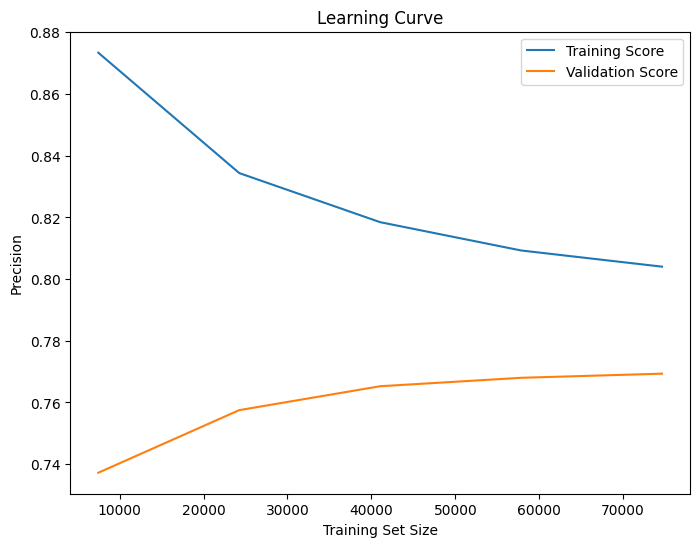

In [21]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(stacked_model, X_train, y_train, cv=3)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Precision')
plt.title('Learning Curve')
plt.legend()
plt.show()